# 1 basic
pytorch 官网案例
- https://github.com/pytorch/examples/tree/main/distributed/ddp-tutorial-series \

Code for the DDP tutorial series at https://pytorch.org/tutorials/beginner/ddp_series_intro.html

Each code file extends upon the previous one. The series starts with a non-distributed script that runs on a single GPU and incrementally updates to end with multinode training on a Slurm cluster.

Files
- single_gpu.py: Non-distributed training script  https://github.com/pytorch/examples/blob/main/distributed/ddp-tutorial-series/single_gpu.py

- multigpu.py: DDP on a single node   https://github.com/pytorch/examples/blob/main/distributed/ddp-tutorial-series/multigpu.py

- multigpu_torchrun.py: DDP on a single node using Torchrun  https://github.com/pytorch/examples/blob/main/distributed/ddp-tutorial-series/multigpu_torchrun.py

- multinode.py: DDP on multiple nodes using Torchrun (and optionally Slurm)  https://github.com/pytorch/examples/blob/main/distributed/ddp-tutorial-series/multinode.py

    - slurm/setup_pcluster_slurm.md: instructions to set up an AWS cluster  https://github.com/pytorch/examples/blob/main/distributed/ddp-tutorial-series/slurm/setup_pcluster_slurm.md
    - slurm/config.yaml.template: configuration to set up an AWS cluster  https://github.com/pytorch/examples/blob/main/distributed/ddp-tutorial-series/slurm/config.yaml.template
    - slurm/sbatch_run.sh: slurm script to launch the training job  https://github.com/pytorch/examples/blob/main/distributed/ddp-tutorial-series/slurm/sbatch_run.sh

## 1.1 单机多卡数据并行
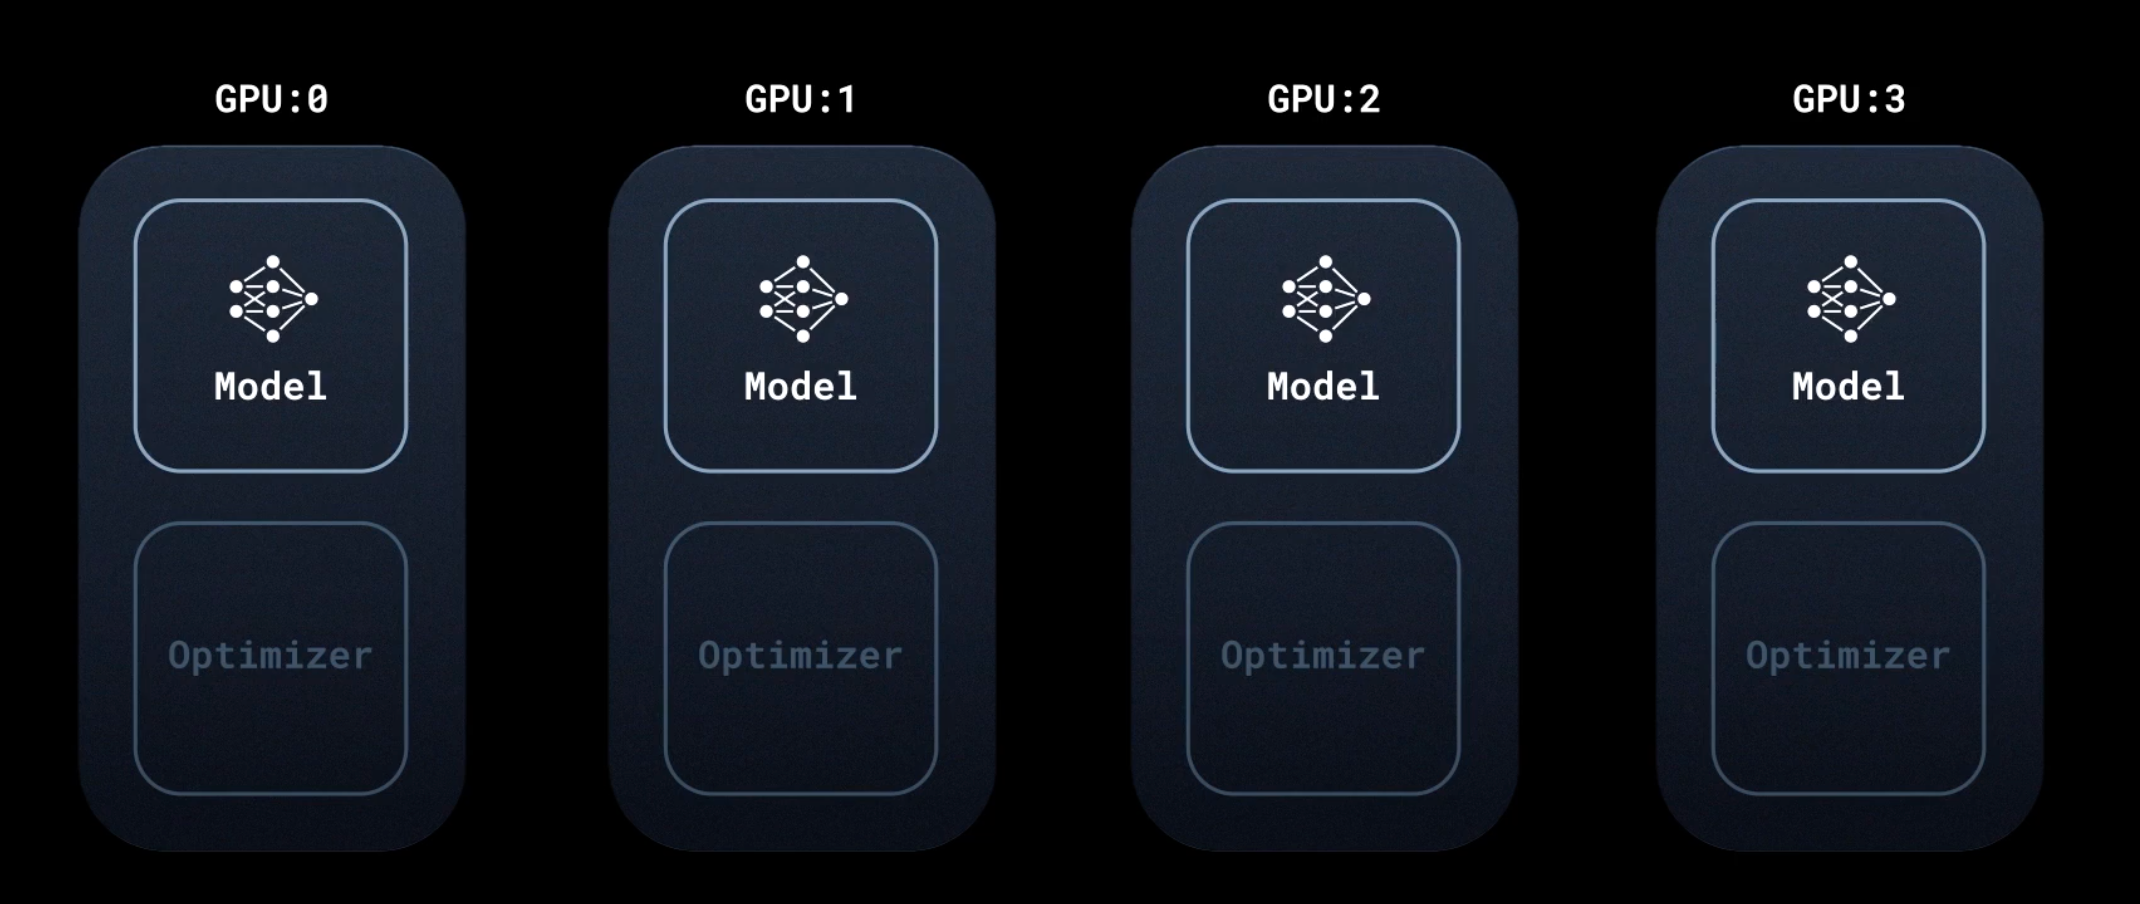

multiple GPUs in a single machine/server/node：单机多卡

- 分布式数据并行时，模型(model parameters) 和 优化器 (optimizer states) 每张卡都会拷贝一份(replicas),  数据并行都会拷贝一份存量
    - DDP始终在卡间同步模型参数和优化器状态的同步一致性
- Data Parallel , batch input 通过DistributedSampler Split 分发到不同的gpus上
    - 此时虽然模型参数和optimier相同，但是因为分批分配的输入数据不同，导致loss不同，反向传播计算的梯度也不同
    - 此时ddp通过ting all-reduce 算法保证model/optimizer的同步一致性

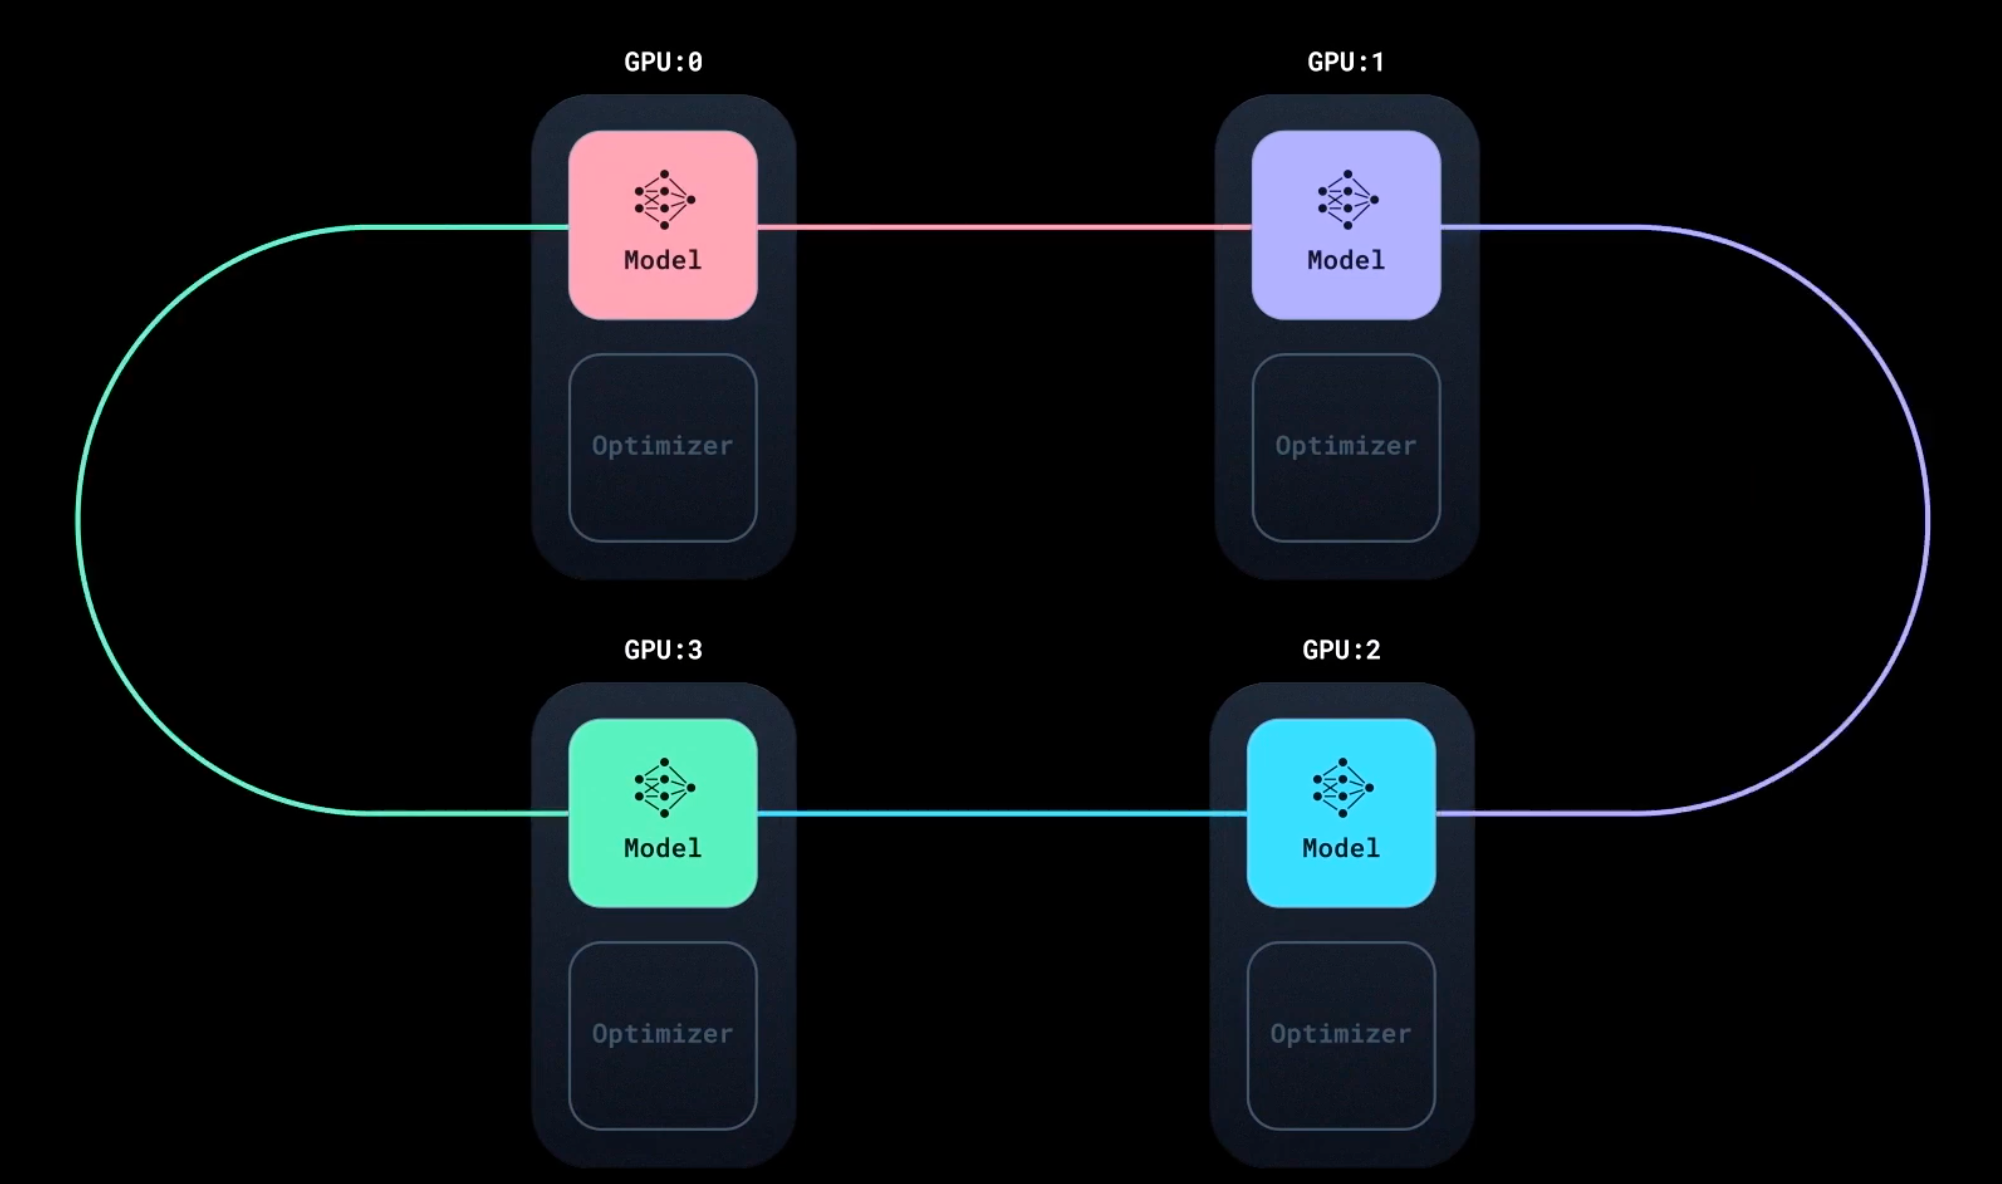
ring all-reduce algorithm
- 首先会将所有的 gpu cards 连成一个 ring
- 其同步过程，不需要等待所有的卡都计算完一轮梯度，
- 经过这个同步过程之后，所有的卡的 models/optimizers 就都会保持一致的状态；

## 1.2 Ring All-Reduce 算法
- 李沐： 参数服务器
    - https://d2l.ai/chapter_computational-performance/parameterserver.html
    - https://www.cs.cmu.edu/~muli/file/ps.pdf
- 计算和同步的几个过程
    - GPUs 分别计算损失（forward）和梯度（backward）
    - 梯度的聚合
    - 模型/优化器）参数的更新及广播（broadcast）；
- HPC（high performance computing）的基础算法
- Ring 环形拓扑结构
    - 百度提出来的；
    - 环形的，logical 的（逻辑的，非物理的）
    - 两个过程（基于环形逻辑拓扑）
        - scatter-reduce
        - all gather（broadcast）

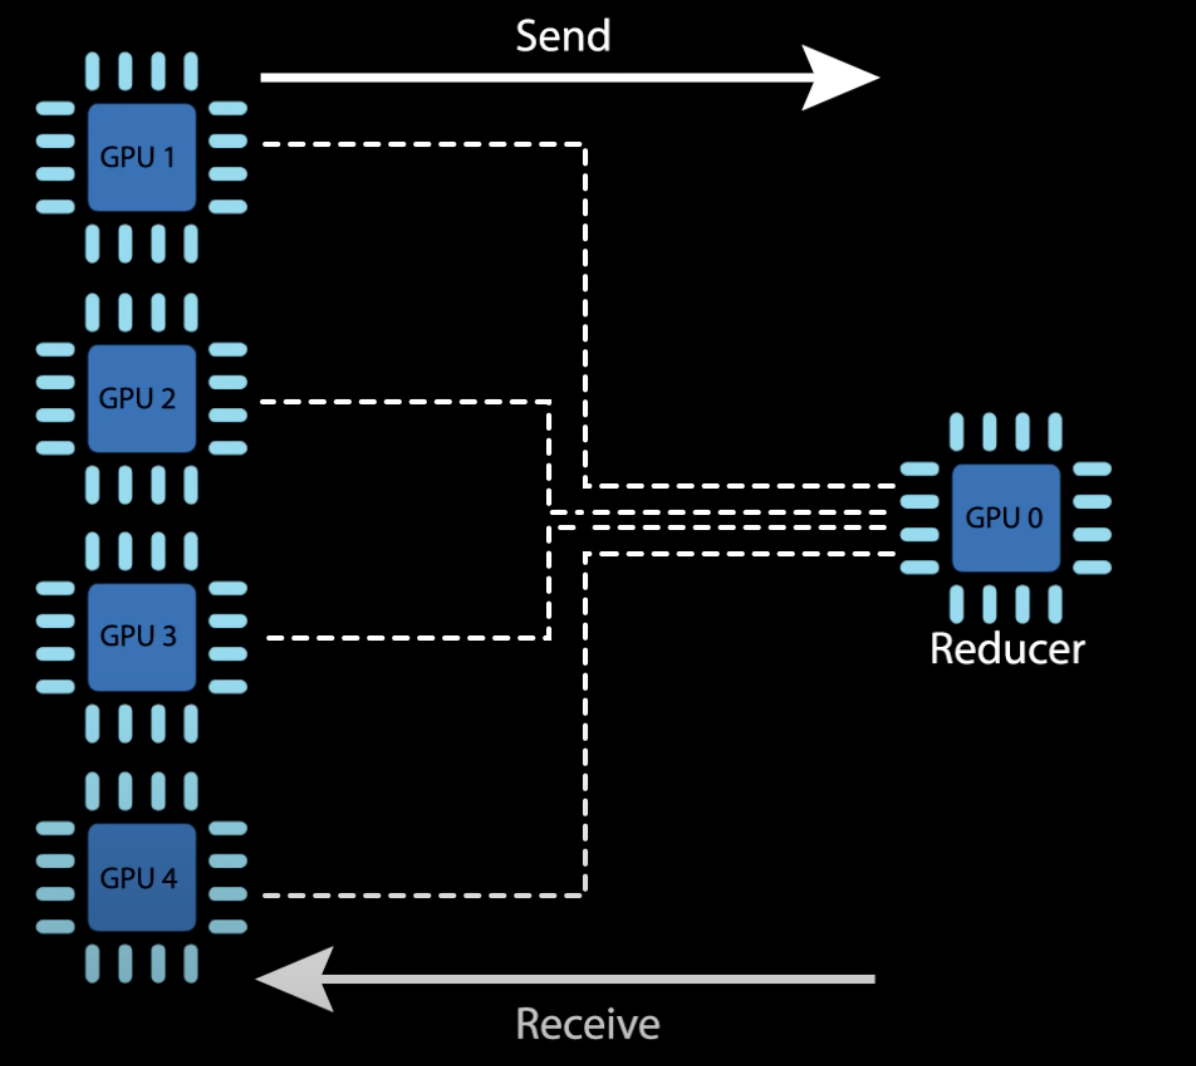

- send data to only one gpu(reducer)
    - 将会引发通信的瓶颈

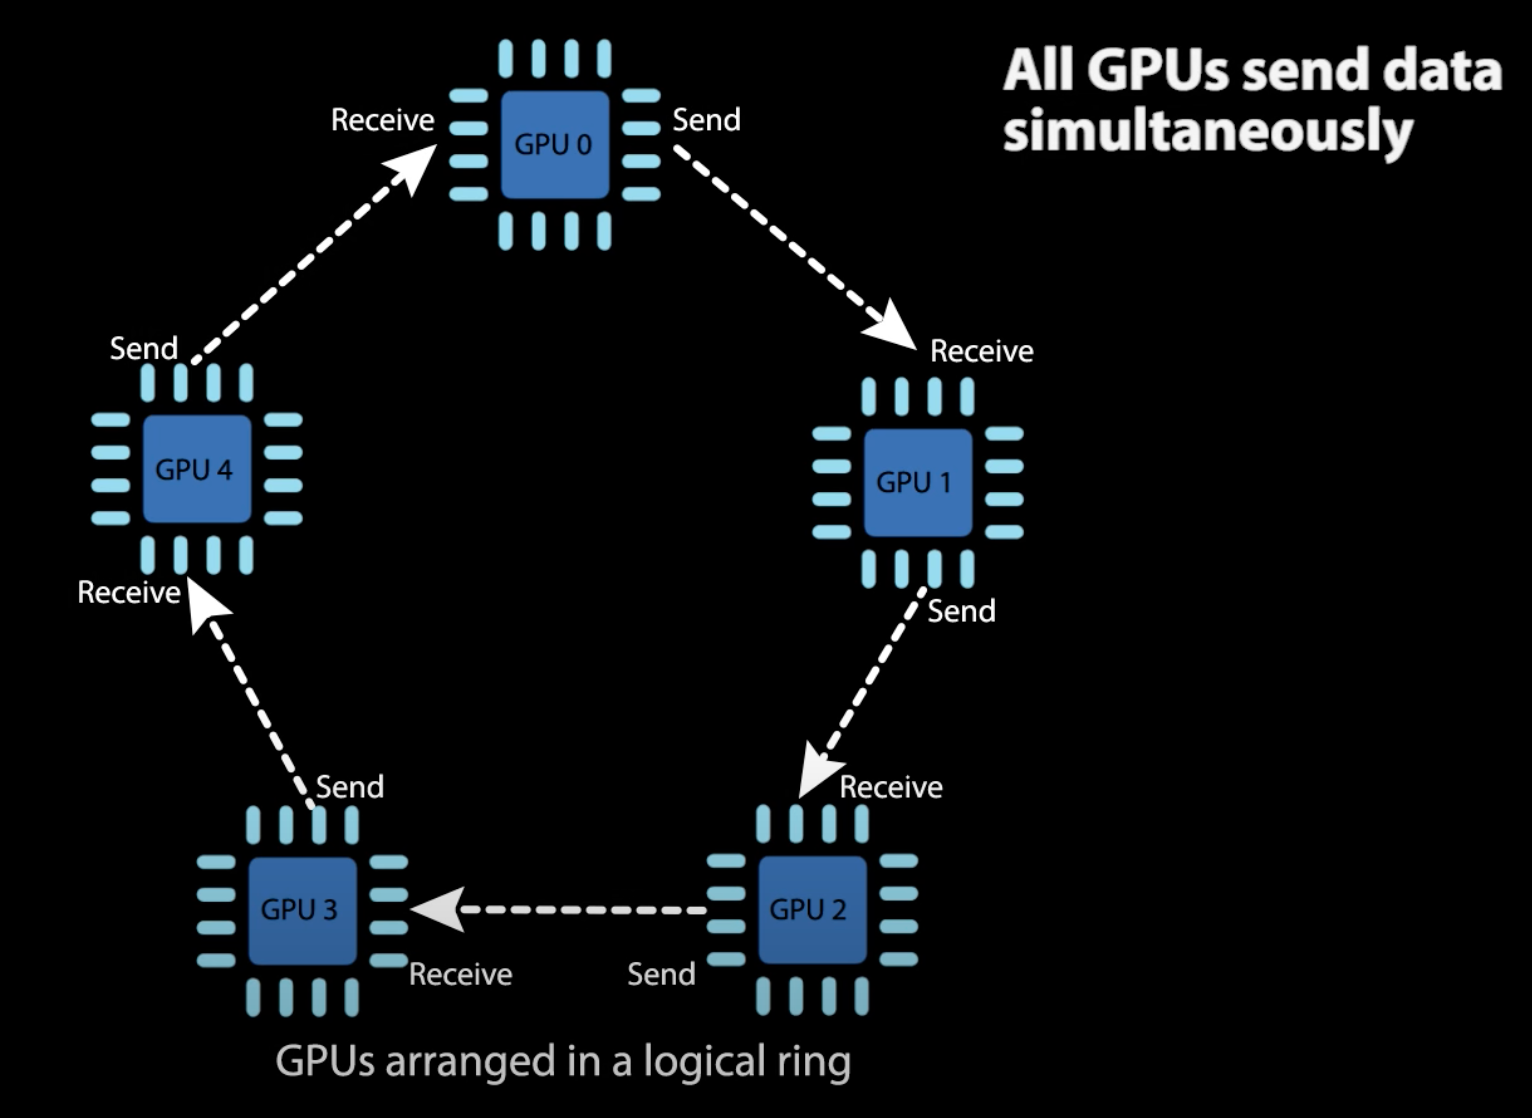
- sending data 花费的时间会更少

# 2 ddp 相关概念
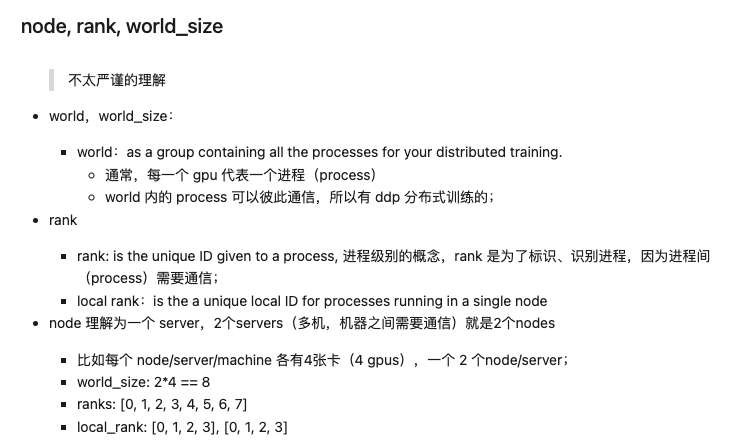


```python
def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)
    ```

misc

```python
if not torch.distributed.is_initialized():
    torch.distributed.init_process_group("nccl")
# torchrun --nproc_per_node 的参数
model_parallel_size = int(os.environ.get("WORLD_SIZE", 1))

local_rank = int(os.environ.get("LOCAL_RANK", 0))

torch.cuda.set_device(local_rank)
```